In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import torch.optim as optim

import numpy as np

np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
from typing import *

tensor = torch.Tensor
hidden_state = Tuple[tensor, tensor]

class NaiveLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        tensor = torch.Tensor
        
        # input gate
        self.W_ii = Parameter(tensor(input_size, hidden_size))
        self.W_hi = Parameter(tensor(hidden_size, hidden_size))
        self.b_i = Parameter(tensor(hidden_size))
        
        # forget gate
        self.W_if = Parameter(tensor(input_size, hidden_size))
        self.W_hf = Parameter(tensor(hidden_size, hidden_size))
        self.b_f = Parameter(tensor(hidden_size))

        # output / use gate
        self.W_io = Parameter(tensor(input_size, hidden_size))
        self.W_ho = Parameter(tensor(hidden_size, hidden_size))
        self.b_o = Parameter(tensor(hidden_size))
        
        # learn? gate
        self.W_il = Parameter(tensor(input_size, hidden_size))
        self.W_hl = Parameter(tensor(hidden_size, hidden_size))
        self.b_l = Parameter(tensor(hidden_size))
        
        self.init_weights()
    
    #idea from: stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    def init_weights(self):
        for parameter in self.parameters():
            if parameter.data.ndimension() > 1: nn.init.xavier_uniform_(parameter.data)
            else: nn.init.zeros_(parameter.data)
        
    def forward(self, x: tensor, init_states: hidden_state) -> Tuple[tensor, hidden_state]:
        sequence_size, batch_size, feature_size = x.size()
        hidden_sequence = []
        h_t, c_t = init_states
            
        for time in range(sequence_size):
            x_t = x[time, :, :]
            
            #from medium.com/@divyanshu132/lstm-and-its-equations-5ee9246d04af
            
            i_t = torch.sigmoid(x_t @ self.W_ii + h_t @ self.W_hi + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_if + h_t @ self.W_hf + self.b_f)
            o_t = torch.sigmoid(x_t @ self.W_io + h_t @ self.W_ho + self.b_o)
            
            l_t = torch.tanh(x_t @ self.W_il + h_t @ self.W_hl + self.b_l)
            
            c_t = f_t * c_t + i_t * l_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_sequence.append(h_t)
            
        hidden_sequence = torch.cat(hidden_sequence)
        
        return hidden_sequence, (h_t, c_t)

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        #LSTM
        self.lstm = NaiveLSTM(input_size, hidden_size)
        self.hidden2Cat = nn.Linear(hidden_size, output_size).to(device)
        self.hidden = self.init_hidden()

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input, self.hidden)
        final_output = lstm_out[-1]
        output = self.hidden2Cat(final_output)
        output = F.log_softmax(output, dim=1)

        return output

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size).to(device),
                torch.zeros(1, 1, self.hidden_size).to(device))

In [16]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import random

def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Build the category_lines dictionary, a list of names per language
category_lines = {}
category_lines_test = {}
all_categories = []
split_size = 0.92


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    split = int(len(lines) * split_size)
    category_lines[category] = lines[0:split]
    category_lines_test[category] = lines[split:-1]

n_categories = len(all_categories)

In [17]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(train_set=True):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category] if train_set else category_lines_test[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# Just return an output given a line
def evaluate(line_tensor):
    rnn.hidden = rnn.init_hidden()
    output = rnn(line_tensor)

    return output

In [18]:
#negative log likelihood loss
criterion = nn.NLLLoss()
learning_rate = 0.0008
n_iters = 28_000

n_hidden = 256
rnn = RNN(n_letters, n_hidden, n_categories) #LSTM model
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

1000 3% (0m 7s) 1.4430 Woo / Chinese ✓
2000 7% (0m 14s) 1.1644 Han / Chinese ✗ (Vietnamese)
3000 10% (0m 21s) 1.8053 Castro / Italian ✗ (Spanish)
4000 14% (0m 27s) 1.1834 Noh / Korean ✓
5000 17% (0m 34s) 1.8768 Belanger / Dutch ✗ (French)
6000 21% (0m 41s) 0.9593 Mendes / Portuguese ✓
7000 25% (0m 48s) 1.6517 Severin / French ✓
8000 28% (0m 56s) 3.4601 Moon / French ✗ (Korean)
9000 32% (1m 3s) 1.1119 Palzewicz / Czech ✓
10000 35% (1m 10s) 0.0461 Kanaan / Arabic ✓
11000 39% (1m 17s) 1.1420 Cormac / French ✗ (Irish)
12000 42% (1m 24s) 0.0004 O'Brian / Irish ✓
13000 46% (1m 32s) 0.0043 O'Meara / Irish ✓
14000 50% (1m 39s) 1.7617 Bartolomeo / Greek ✗ (Italian)
15000 53% (1m 46s) 2.3232 Asis / Arabic ✗ (Spanish)
16000 57% (1m 54s) 2.6049 Solomon / Polish ✗ (French)
17000 60% (2m 1s) 0.2350 Raikatuji / Japanese ✓
18000 64% (2m 8s) 0.4249 Deniau / French ✓
19000 67% (2m 16s) 0.1943 Abatangelo / Italian ✓
20000 71% (2m 23s) 0.5369 Nosek / Polish ✓
21000 75% (2m 30s) 0.0147 Agnelli / Italian ✓


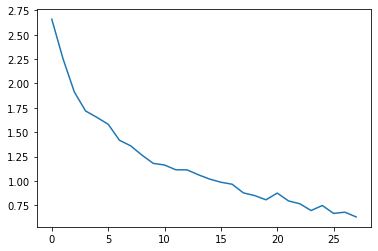

In [19]:
import time
import math
import matplotlib.pyplot as plt

def train(category_tensor, line_tensor):

    rnn.zero_grad()
    rnn.hidden = rnn.init_hidden()

    output = rnn(line_tensor)[-1]

    loss = criterion(output.unsqueeze(0), category_tensor)
    loss.backward()

    optimizer.step()

    return output.unsqueeze(0), loss.item()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

print_every = 1_000
plot_every = 1_000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor.to(device), line_tensor.to(device))
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
# Show the loss
plt.figure()
plt.plot(all_losses)
plt.show()

In [20]:
def confusion_plot(y_category, train_set=True):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 50_000
    correct = 0
    
    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):

        category, line, category_tensor, line_tensor = randomTrainingExample(train_set)
        output = evaluate(line_tensor.to(device))
        output = output.unsqueeze(0)

        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1
        if category_i == guess_i: correct += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + y_category, rotation=90)
    ax.set_yticklabels([''] + y_category)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    print(f"accuracy = {correct / n_confusion}")

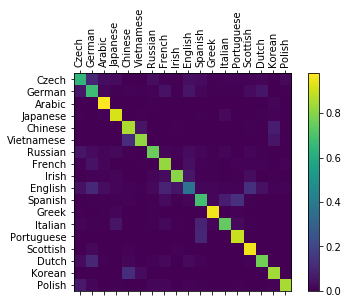

accuracy = 0.7985


In [21]:
confusion_plot(all_categories)

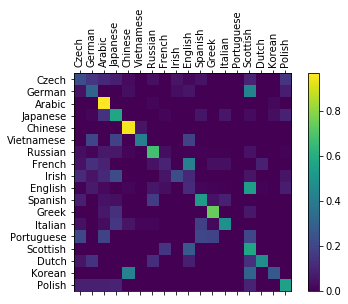

accuracy = 0.45734


In [22]:
confusion_plot(all_categories, False)

In [23]:
def predict(word, n_predictions=4):
        print(f'\n>{word}')
        with torch.no_grad():
            output = evaluate(lineToTensor(word))

            # get top N categories
            topv, topi = output.topk(n_predictions, 1, True)
            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                print('(%.2f) %s' % (value, all_categories[category_index]))


In [24]:
predict("Zhao")
predict("Alah")
predict("Shiomi")
predict("Connor")
predict("Hernandez")
predict("Voltaire")
predict("Paganni")
predict("Schneider")
predict("Yun")
predict("Sayaka")
predict("Tomoyo")
predict("Alah")
predict("Perez")



>Zhao
(-0.00) Chinese
(-8.32) Scottish
(-9.24) Vietnamese
(-9.42) Japanese

>Alah
(-0.76) Arabic
(-1.28) Scottish
(-2.27) Irish
(-3.02) English

>Shiomi
(-0.00) Japanese
(-7.00) Arabic
(-9.63) Italian
(-9.68) Czech

>Connor
(-0.67) French
(-1.96) Irish
(-2.22) English
(-2.69) Spanish

>Hernandez
(-0.10) Spanish
(-2.33) Portuguese
(-6.85) Czech
(-7.40) German

>Voltaire
(-0.54) French
(-1.79) German
(-2.46) Russian
(-2.56) English

>Paganni
(-0.00) Italian
(-6.14) Japanese
(-7.08) Spanish
(-7.26) Russian

>Schneider
(-0.92) Czech
(-1.19) Dutch
(-1.33) German
(-4.16) English

>Yun
(-0.03) Chinese
(-3.49) Korean
(-7.56) Dutch
(-7.98) Scottish

>Sayaka
(-0.02) Japanese
(-4.23) Arabic
(-7.01) Czech
(-10.02) Polish

>Tomoyo
(-0.00) Japanese
(-8.37) Italian
(-8.71) Spanish
(-9.43) Greek

>Alah
(-0.76) Arabic
(-1.28) Scottish
(-2.27) Irish
(-3.02) English

>Perez
(-0.02) Spanish
(-4.89) Portuguese
(-5.18) German
(-6.22) Czech
